<hr style="border:1px solid gray">

## phase retrieval algorithm
created: **10/07/2023**; last edited: **24/07/2023**

[rafael.celestre@esrf.eu](mailto:rafael.celestre@esrf.eu)

<hr style="border:1px solid gray">

In [1]:
# checking we are using the correct python:
import sys

print(sys.executable)
print(sys.version)
sys.path.insert(0, '../srwpy/')

# %matplotlib notebook
%matplotlib inline

import timeit
from copy import copy
import numpy as np
import pickle
from scipy.interpolate import RectBivariateSpline, interp1d
from scipy.signal import peak_widths

from PIL import Image
import glob

from skimage.restoration import unwrap_phase

import xraylib as xl                         # get xraylib: https://anaconda.org/conda-forge/xraylib

try:
    from srwlib import *                     # uses SRW repository
    from uti_plot import *
    print('SRW distribution of SRW')
except:
    from oasys_srw.srwlib import *           # get oasys_srw: https://github.com/oasys-kit/OASYS1-srwpy
    from oasys_srw.uti_plot import *
    print('OASYS distribution of SRW')
    
import barc4plots.barc4plots as b4pt         # get barc4plots: https://gitlab.esrf.fr/celestre/barc4plots


/home/esrf/celestre/miniconda/envs/xog/bin/python
3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
SRW distribution of SRW


<hr style="border:5px solid orange">

### Definition of the beamline:

X-ray beam (parabolic beam with Gaussian amplitude $\sigma=1~$mm) at E=12.398 keV illuminating a 20x Be $R=50~\mu$m CRL located at $D=50~$m dowstream the source S. The phase plate PP is located $dx=10~$mm dowstream the CRL.


```
S                               CRL  PP   F
X-------------------------------|||---)---x
.                                .    .   .
<-------------------------------> <--> <->
                 D                 dx 

```



In [2]:
beam_energy = 12398  # [eV]

# ---------- beamline characteristics
posLens = 50               # initial position in [m]
posPP = 0.1                # phase plate position [m]
sampling_factor = .00
emittance_x = 1
emittance_y = 1

# axis for lens calculations
x = [-1e-3, 1e-3, 501]     # xi, xf, nx
y = x

source = 'g'               # u - undulator; g - Gaussian

show_source = False
show_input_beam = False
show_psf = False


In [3]:
# ---------------------------------------
# utils ---------------------------------
# ---------------------------------------

def get_intensity(wavefront, reshape=False):
    """

    :param wavefront: wavefront
    :param reshape: (bool) C - type array or 2d numpy array

    :return: intensity, x and y axis
    """

    mesh = deepcopy(wavefront.mesh)

    arI = array('f', [0] * mesh.nx * mesh.ny)
    srwl.CalcIntFromElecField(arI, wavefront, 6, 0, 3, mesh.eStart, 0, 0)

    if reshape:
        x = np.linspace(mesh.xStart, mesh.xFin, mesh.nx)
        y = np.linspace(mesh.yStart, mesh.yFin, mesh.ny)
        intensity = np.reshape(arI, (mesh.ny, mesh.nx))

        return intensity, x, y

    else:
        return arI


def get_phase(wavefront, reshape=False):
    """

    :param wavefront: wavefront
    :param reshape: (bool) C - type array or 2d numpy array

    :return: intensity, x and y axis
    """
    mesh = deepcopy(wavefront.mesh)

    arP = array('d', [0] * mesh.nx * mesh.ny)
    srwl.CalcIntFromElecField(arP, wavefront, 0, 4, 3, mesh.eStart, 0, 0)

    if reshape:
        x = np.linspace(mesh.xStart, mesh.xFin, mesh.nx)
        y = np.linspace(mesh.yStart, mesh.yFin, mesh.ny)
        phase = np.reshape(arP, (mesh.ny, mesh.nx))

        return phase, x, y

    else:
        return arP


def wavefront_stats(wavefront):
    """

    :param wavefront:
    :return:
    """
    print('\n >>> Wavefront:')
    print('Nx = %d, Ny = %d' % (wavefront.mesh.nx, wavefront.mesh.ny))
    print('dx = %.4f um, dy = %.4f um' % ((wavefront.mesh.xFin - wavefront.mesh.xStart)* 1E6 / wavefront.mesh.nx,
                                          (wavefront.mesh.yFin - wavefront.mesh.yStart)* 1E6 / wavefront.mesh.ny))
    print('range x = %.4f mm, range y = %.4f mm' % ((wavefront.mesh.xFin - wavefront.mesh.xStart) * 1E3,
                                                    (wavefront.mesh.yFin - wavefront.mesh.yStart) * 1E3))
    print('Rx = %.6f, Ry = %.6f' % (wavefront.Rx, wavefront.Ry))


def get_fwhm(image, x, y):
    """

    :param image:
    :param x:
    :param y:
    :return:
    """

    def _fwhm(y_axis, x_axis):
        y_axis -= np.amin(y_axis)
        y_axis = y_axis / np.amax(y_axis)
        x_max = np.argmax(y_axis)
        hwhm_r = -1
        hwhm_l = -1
        k = 0
        while hwhm_r == -1:
            k += 1
            if x_max + k >= x_axis.size:
                break
            if y_axis[x_max + k] <= 0.5:
                hwhm_r = x_axis[x_max + k]

        if hwhm_r == -1:
            hwhm_r = x_axis[-1]
        else:
            hwhm_r = np.interp(0.5, y_axis[x_max + k - 3:x_max + k + 3].flatten(),
                               x_axis[x_max + k - 3:x_max + k + 3].flatten())

        k = 0
        while hwhm_l == -1:
            k -= 1
            if x_max + k <= 0:
                break
            if y_axis[x_max + k] <= 0.5:
                hwhm_l = x_axis[x_max + k]

        if hwhm_l == -1:
            hwhm_l = x_axis[0]
        else:
            hwhm_l = np.interp(0.5, y_axis[x_max + k - 3:x_max + k + 3].flatten(),
                               x_axis[x_max + k - 3:x_max + k + 3].flatten())

        return hwhm_r - hwhm_l

    vertical_cut = image[:, int(len(x) / 2)]
    horizontal_cut = image[int(len(y) / 2), :]

    return _fwhm(horizontal_cut, x), _fwhm(vertical_cut, y)


def plot_wavefront(wavefront, units='um', phase=True, **kwargs):
    """

    :param wavefront:
    :param units:
    :param phase:
    :param plt_limits: (optional)
    :param ax_limits: (optional)
    :param file_name: (optional)

    :return:
    """

    if units == 'mm':
        factor = 1e3
    elif units == 'um':
        factor = 1e6
        units = '$\mu$m'
    try:
        show = kwargs['show']  # [min max]
    except:
        show = True

    try:
        graph_name = kwargs['graph_name']
    except:
        graph_name = ''

    intensity, x, y = get_intensity(wavefront, reshape=True)

    image = b4pt.Image2Plot(intensity, x * factor, y * factor)
    image.legends = [graph_name, units, units]
    image.Colorbar = True
    image.LaTex = True
    image.AspectRatio = True
    image.ColorScheme = 2
    try:
        image.plt_limits = kwargs['plt_limits']  # [min max]
    except:
        pass
    try:
        image.ax_limits = kwargs['ax_limits']  # [-x, x, -y, y]
    except:
        pass
    image.FontsSizeScale = 1.3
    image.sort_class()
    try:
        b4pt.plot_2D_cuts(image, kwargs['file_name'] + '_intensity.png', Enable=show, Silent=np.logical_not(show),
                          dpi=400)
    except:
        b4pt.plot_2D_cuts(image, Enable=show, Silent=np.logical_not(show), dpi=400)

    if phase:
        unwrap = kwargs.get('unwrap')
        phase, x, y = get_phase(wavefront, reshape=True)

        if unwrap is True:
            image = b4pt.Image2Plot(unwrap_phase(phase), x * factor, y * factor)
            image.ColorScheme = 5
        else:
            image = b4pt.Image2Plot(phase, x * factor, y * factor)
            image.ColorScheme = 12

        image.legends = ['', units, units]
        image.Colorbar = True
        image.LaTex = True
        image.AspectRatio = True
        try:
            image.ax_limits = kwargs['ax_limits']
        except:
            pass
        image.FontsSizeScale = 1.3
        image.sort_class()
        try:
            b4pt.plot_2D_cuts(image, kwargs['file_name'] + '_phase.png', Enable=show, Silent=np.logical_not(show),
                              dpi=400)
        except:
            b4pt.plot_2D_cuts(image, Enable=show, Silent=np.logical_not(show), dpi=400)

<hr style="border:1px solid orange">

#### Illumination:

In [4]:
#############################################################################
# Source generation

print('>>> Source generation:')

wfr_resolution = (x[2], y[2])  # nx, ny
screen_range = (x[0], x[1], y[0], y[1])  # x_Start, x_Fin, y_Start, y_Fin
wavelength = srwl_uti_ph_en_conv(beam_energy, _in_u='eV', _out_u='m')

mesh = SRWLRadMesh(_eStart=beam_energy,
                   _eFin  =beam_energy,
                   _ne    =1,
                   _xStart= screen_range[0],
                   _xFin  = screen_range[1],
                   _nx    = wfr_resolution[0],
                   _yStart= screen_range[2],
                   _yFin  = screen_range[3],
                   _ny    = wfr_resolution[1],
                   _zStart=posLens)

#********************************Storage ring parameters
wfr = SRWLWfr()
wfr.allocate(mesh.ne, mesh.nx, mesh.ny)
wfr.unitElFld = 1
wfr.mesh = mesh
part_beam = SRWLPartBeam()
part_beam.Iavg = 0.2
part_beam.partStatMom1.x = 0.0
part_beam.partStatMom1.y = 0.0
part_beam.partStatMom1.z = 0.0    # if source == 'u': -0.5*undPer*(numPer + 4)
part_beam.partStatMom1.xp = 0.0
part_beam.partStatMom1.yp = 0.0

# e- beam paramters (RMS) EBS
sigEperE = 9.3E-4  # relative RMS energy spread
sigX = 30.3E-06  # horizontal RMS size of e-beam [m]
sigXp = 4.4E-06  # horizontal RMS angular divergence [rad]
sigY = 3.6E-06  # vertical RMS size of e-beam [m]
sigYp = 1.46E-06  # vertical RMS angular divergence [rad]

part_beam.partStatMom1.gamma = 6.00 / 0.51099890221e-03  # Relative Energy
part_beam.arStatMom2[0] = sigX*sigX*np.sqrt(emittance_x)     # <(x-<x>)^2>
part_beam.arStatMom2[1] = 0.0                                # <(x-<x>)(x'-<x'>)>
part_beam.arStatMom2[2] = sigXp*sigXp*np.sqrt(emittance_x)   # <(x'-<x'>)^2>
part_beam.arStatMom2[3] = sigY*sigY*np.sqrt(emittance_y)     # <(y-<y>)^2>
part_beam.arStatMom2[4] = 0.0                                # <(y-<y>)(y'-<y'>)>
part_beam.arStatMom2[5] = sigYp*sigYp*np.sqrt(emittance_y)   # <(y'-<y'>)^2>
part_beam.arStatMom2[10] = sigEperE*sigEperE                 # <(E-<E>)^2>/<E>^2

wfr.partBeam = part_beam

if source == 'u':   # undulator
    #********************************Undulator parameters (cmpu18)
    numPer = 74         # Number of ID Periods
    undPer = 0.018252   # Period Length [m]
    phB = 0             # Initial Phase of the Horizontal field component
    sB = 1              # Symmetry of the Horizontal field component vs Longitudinal position
    xcID = 0            # Transverse Coordinates of Undulator Center [m]
    ycID = 0
    zcID = 0

    #********************************Storage ring parameters
    part_beam.partStatMom1.z = -0.5*undPer*(numPer + 4)    # initial Longitudinal Coordinate (set before the ID)

    n = 1
    if (2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1)) <= 0:
        n=3
        if (2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1)) <= 0:
            n = 5
            if (2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1)) <= 0:
                n = 7

    K = np.sqrt(2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1))
    B = K / (undPer * 93.3728962)  # Peak Horizontal field [T] (undulator)
    print('Using B=%.6f [T] (K=%.6f) for n=%d' % (B, K, n)) if (srwl_uti_proc_is_master()) else 0


    # Electron trajectory
    eTraj = 0

    # Precision parameters
    arPrecSR = [0]*7
    arPrecSR[0] = 1     # SR calculation method: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"
    arPrecSR[1] = 0.01  # relative precision
    arPrecSR[2] = 0     # longitudinal position to start integration (effective if < zEndInteg)
    arPrecSR[3] = 0     # longitudinal position to finish integration (effective if > zStartInteg)
    arPrecSR[4] = 30000 # Number of points for trajectory calculation
    arPrecSR[5] = 1     # Use "terminating terms"  or not (1 or 0 respectively)
    arPrecSR[6] = sampling_factor # sampling factor for adjusting nx, ny (effective if > 0)

    und = SRWLMagFldU([SRWLMagFldH(n, 'v', B, phB, sB, 1)], undPer, numPer)
    magFldCnt = SRWLMagFldC([und], array('d', [xcID]), array('d', [ycID]), array('d', [zcID]))

    print('- Undulator Initial Electric Field calculation...\n') if (srwl_uti_proc_is_master()) else 0
    srwl.CalcElecFieldSR(wfr, eTraj, magFldCnt, arPrecSR)
    
else:   # Gaussian beam
        GsnBm = SRWLGsnBm()
        GsnBm.x = 0
        GsnBm.y = 0
        GsnBm.z = 0
        GsnBm.xp = 0
        GsnBm.yp = 0
        GsnBm.avgPhotEn = beam_energy
        GsnBm.pulseEn = 0.001
        GsnBm.repRate = 1
        GsnBm.polar = 1
        GsnBm.sigX = 10e-7 / 2.35
        GsnBm.sigY = GsnBm.sigX
        GsnBm.sigT = 10e-15
        GsnBm.mx = 0
        GsnBm.my = 0

        constConvRad = 1.23984186e-06 / (4 * 3.1415926536)
        rmsAngDiv = constConvRad / (GsnBm.avgPhotEn * GsnBm.sigX)  # RMS angular divergence [rad]
        print('RMS Source Size:', round(GsnBm.sigX * 1.e+06, 3), 'um; RMS Divergence:', round(rmsAngDiv * 1.e+06, 3), 'urad') if (srwl_uti_proc_is_master()) else 0

        magnetic_field_container = GsnBm
        arPrecPar = [sampling_factor]

        print('- Gaussian beam Initial Electric Field calculation... ') if (srwl_uti_proc_is_master()) else 0
        srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)

wavefront_stats(wfr)

if show_source:
#     plot_srw_wavefront(wfr)
    plot_wavefront(wfr, units='mm', phase=True, unwrap=False)


>>> Source generation:
RMS Source Size: 0.426 um; RMS Divergence: 18.701 urad
- Gaussian beam Initial Electric Field calculation... 

 >>> Wavefront:
Nx = 501, Ny = 501
dx = 3.9920 um, dy = 3.9920 um
range x = 2.0000 mm, range y = 2.0000 mm
Rx = 50.000000, Ry = 50.000000


<hr style="border:1px solid orange">

#### The **SRW** propagators:
```
[ 0]: Auto-Resize (1) or not (0) Before propagation
[ 1]: Auto-Resize (1) or not (0) After propagation
[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
[ 3]: Type of Free-Space Propagator:
       0- Standard Fresnel
       1- Fresnel with analytical treatment of the quadratic (leading) phase terms
       2- Similar to 1, yet with different processing near a waist
       3- For propagation from a waist over a ~large distance
       4- For propagation over some distance to a waist
       5- Huygens-Fresnel diffraction integral (only after commit 34)
[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
[ 5]: Horizontal range modification factor at Resizing (1. means no modification)
[ 6]: Horizontal Resolution modification factor at Resizing
[ 7]: Vertical range modification factor at Resizing
[ 8]: Vertical Resolution modification factor at Resizing
[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
[11]: New Vertical wavefront Center position after Shift (not yet implemented)
```


<hr style="border:1px solid orange">

#### Loading phase from GS algorithm:


 >>> Wavefront:
Nx = 5040, Ny = 5040
dx = 0.6546 um, dy = 0.6546 um
range x = 3.2994 mm, range y = 3.2994 mm
Rx = -0.470321, Ry = -0.470321
>>>>> input beam


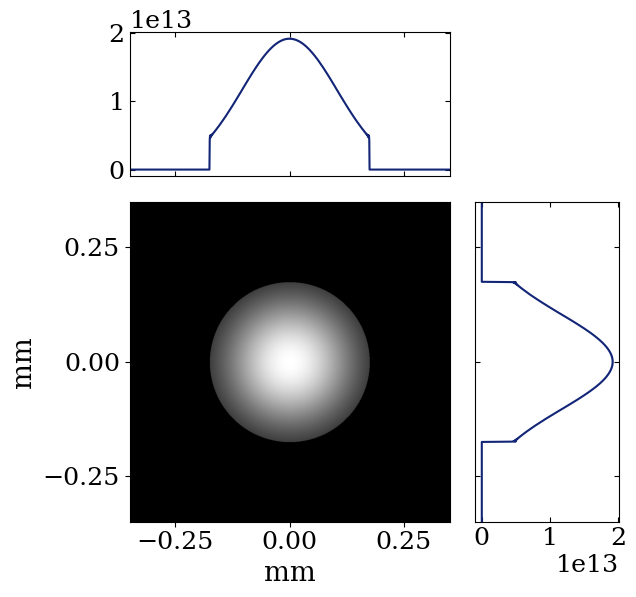

In [5]:
dist=15e-3
cst_pts = 500

folder = './results/'
file_tag = 'rgaussian_1000_iterations'
file = open(folder+file_tag+'.pickle', 'rb')

wfrp = pickle.load(file)
file.close()

wavefront_stats(wfrp)

print('>>>>> input beam')
plot_wavefront(wfrp, units='mm', phase=False, unwrap=False,
               ax_limits=[-0.35, 0.35, -0.35, 0.35])

<hr style="border:1px solid orange">

#### Loading phase from GS algorithm:

- Simulating Electric Field Wavefront Propagation ... 

 >>> Wavefront:
Nx = 5040, Ny = 5040
dx = 0.0210 um, dy = 0.0210 um
range x = 0.1059 mm, range y = 0.1059 mm
Rx = -0.015000, Ry = -0.015000


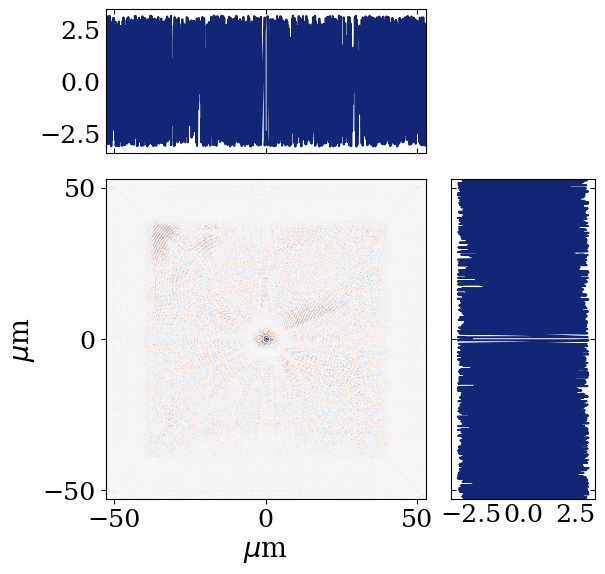

In [6]:
input_beam = deepcopy(wfrp)

srw_oe_array = []
srw_pp_array = []

# ---------- drift to the image plane
pp_to_image = -(input_beam.Rx + input_beam.Ry)/2 - dist
oeDrift = SRWLOptD(pp_to_image)

pp = [0, 0, 1, 1, 0, 1., 1., 1., 1., 0, 0, 0]
srw_oe_array.append(oeDrift)
srw_pp_array.append(pp)

optBL = SRWLOptC(srw_oe_array, srw_pp_array)

print('- Simulating Electric Field Wavefront Propagation ... ')
srwl.PropagElecField(input_beam, optBL)

# srw_oe_array = []
# srw_pp_array = []
# pp_to_image = dist
# oeDrift = SRWLOptD(pp_to_image)
# pp = [0, 0, 1, 1, 0, 1., 1., 1., 1., 0, 0, 0]
# srw_oe_array.append(oeDrift)
# srw_pp_array.append(pp)
# optBL = SRWLOptC(srw_oe_array, srw_pp_array)
# print('- Simulating Electric Field Wavefront Propagation ... ')
# srwl.PropagElecField(input_beam, optBL)

wavefront_stats(input_beam)
plot_wavefront(input_beam, units='um', phase=True, unwrap=False)

In [7]:
wft_cst = deepcopy(input_beam)
cst_range = [-np.abs(dist), np.abs(dist)]
pp = [0, 0, 1, 0, 0, 1., 1., 1., 1., 0, 0, 0]
IntVsZX, IntVsZY, cstcMesh = srwl_wfr_prop_drifts(wft_cst, (cst_range[1] - cst_range[0])/cst_pts,  cst_pts,
                                                  pp, _pol=6, _type=0)
# cstc vs X
mesh_cstc_x = copy(cstcMesh)
mesh_cstc_x.xStart = cst_range[0]
mesh_cstc_x.xFin = cst_range[1]
mesh_cstc_x.nx = cst_pts + 1
mesh_cstc_x.yStart = cstcMesh.xStart
mesh_cstc_x.yFin = cstcMesh.xFin
mesh_cstc_x.ny = cstcMesh.nx

# cstc vs Y
mesh_cstc_y = copy(cstcMesh)
mesh_cstc_y.xStart = cst_range[0]
mesh_cstc_y.xFin = cst_range[1]
mesh_cstc_y.nx = cst_pts + 1
mesh_cstc_y.yStart = cstcMesh.yStart
mesh_cstc_y.yFin = cstcMesh.yFin
mesh_cstc_y.ny = cstcMesh.ny

srwl_uti_save_intens_ascii(IntVsZX, mesh_cstc_x, folder+file_tag+'_cstX' + '.dat', 0)
srwl_uti_save_intens_ascii(IntVsZY, mesh_cstc_y, folder+file_tag+'_cstY' + '.dat', 0)
print('>> caustic calculations: done')


Propagation (step # 1) ... completed (lasted 4.872071 s)
Propagation (step # 2) ... completed (lasted 4.858423 s)
Propagation (step # 3) ... completed (lasted 4.815598 s)
Propagation (step # 4) ... completed (lasted 4.801391 s)
Propagation (step # 5) ... completed (lasted 4.808072 s)
Propagation (step # 6) ... completed (lasted 4.855693 s)
Propagation (step # 7) ... completed (lasted 4.843839 s)
Propagation (step # 8) ... completed (lasted 4.806954 s)
Propagation (step # 9) ... completed (lasted 4.837486 s)
Propagation (step # 10) ... completed (lasted 4.839566 s)
Propagation (step # 11) ... completed (lasted 4.830325 s)
Propagation (step # 12) ... completed (lasted 4.811429 s)
Propagation (step # 13) ... completed (lasted 4.836787 s)
Propagation (step # 14) ... completed (lasted 4.812349 s)
Propagation (step # 15) ... completed (lasted 4.857755 s)
Propagation (step # 16) ... completed (lasted 4.833284 s)
Propagation (step # 17) ... completed (lasted 4.837841 s)
Propagation (step # 18)

Propagation (step # 144) ... completed (lasted 4.785664 s)
Propagation (step # 145) ... completed (lasted 4.758631 s)
Propagation (step # 146) ... completed (lasted 4.793193 s)
Propagation (step # 147) ... completed (lasted 4.747983 s)
Propagation (step # 148) ... completed (lasted 4.833758 s)
Propagation (step # 149) ... completed (lasted 4.829076 s)
Propagation (step # 150) ... completed (lasted 4.841897 s)
Propagation (step # 151) ... completed (lasted 4.83104 s)
Propagation (step # 152) ... completed (lasted 4.866653 s)
Propagation (step # 153) ... completed (lasted 4.810626 s)
Propagation (step # 154) ... completed (lasted 4.833684 s)
Propagation (step # 155) ... completed (lasted 4.83764 s)
Propagation (step # 156) ... completed (lasted 4.812793 s)
Propagation (step # 157) ... completed (lasted 4.852255 s)
Propagation (step # 158) ... completed (lasted 4.856482 s)
Propagation (step # 159) ... completed (lasted 4.817295 s)
Propagation (step # 160) ... completed (lasted 4.817257 s)

Propagation (step # 283) ... completed (lasted 4.835705 s)
Propagation (step # 284) ... completed (lasted 4.801365 s)
Propagation (step # 285) ... completed (lasted 4.805775 s)
Propagation (step # 286) ... completed (lasted 4.829686 s)
Propagation (step # 287) ... completed (lasted 4.875036 s)
Propagation (step # 288) ... completed (lasted 4.81431 s)
Propagation (step # 289) ... completed (lasted 4.813766 s)
Propagation (step # 290) ... completed (lasted 4.854866 s)
Propagation (step # 291) ... completed (lasted 4.835062 s)
Propagation (step # 292) ... completed (lasted 4.823303 s)
Propagation (step # 293) ... completed (lasted 4.806066 s)
Propagation (step # 294) ... completed (lasted 4.829788 s)
Propagation (step # 295) ... completed (lasted 4.804836 s)
Propagation (step # 296) ... completed (lasted 4.844444 s)
Propagation (step # 297) ... completed (lasted 4.757895 s)
Propagation (step # 298) ... completed (lasted 4.783934 s)
Propagation (step # 299) ... completed (lasted 4.751861 s

Propagation (step # 423) ... completed (lasted 4.823423 s)
Propagation (step # 424) ... completed (lasted 4.853723 s)
Propagation (step # 425) ... completed (lasted 4.839687 s)
Propagation (step # 426) ... completed (lasted 4.832817 s)
Propagation (step # 427) ... completed (lasted 4.812098 s)
Propagation (step # 428) ... completed (lasted 4.833665 s)
Propagation (step # 429) ... completed (lasted 4.815113 s)
Propagation (step # 430) ... completed (lasted 4.84918 s)
Propagation (step # 431) ... completed (lasted 4.815054 s)
Propagation (step # 432) ... completed (lasted 4.842808 s)
Propagation (step # 433) ... completed (lasted 4.805835 s)
Propagation (step # 434) ... completed (lasted 4.855292 s)
Propagation (step # 435) ... completed (lasted 4.832858 s)
Propagation (step # 436) ... completed (lasted 4.795588 s)
Propagation (step # 437) ... completed (lasted 4.866076 s)
Propagation (step # 438) ... completed (lasted 4.799279 s)
Propagation (step # 439) ... completed (lasted 4.749628 s

- Simulating Electric Field Wavefront Propagation ... 

 >>> Wavefront:
Nx = 5040, Ny = 5040
dx = 0.0210 um, dy = 0.0210 um
range x = 0.1059 mm, range y = 0.1059 mm
Rx = -0.015000, Ry = -0.015000


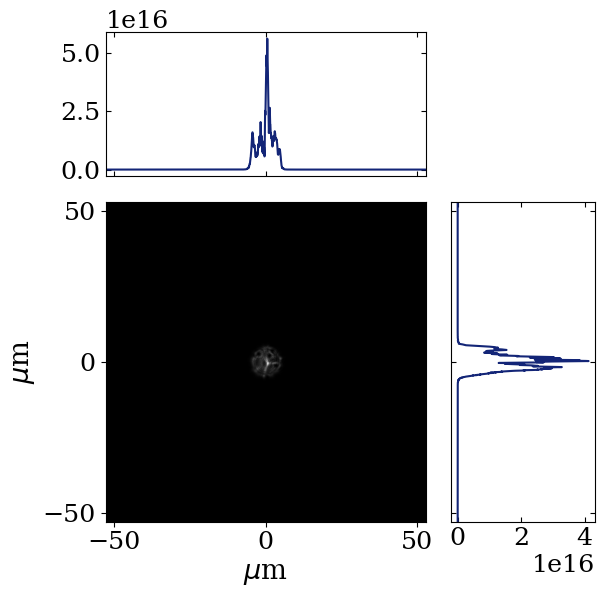

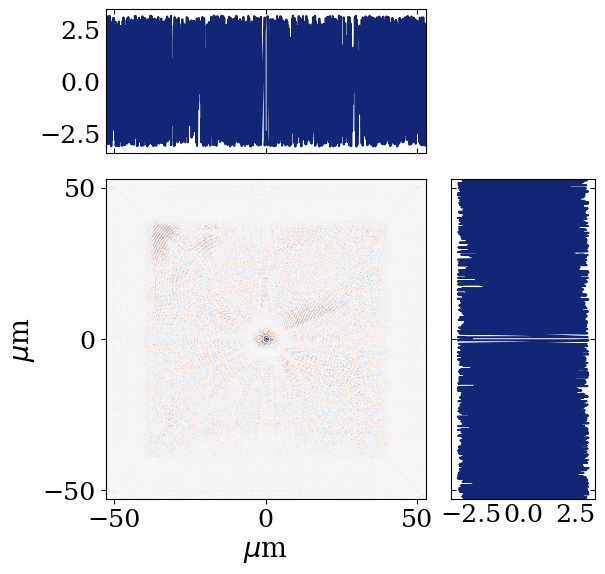

In [8]:
input_beam = deepcopy(wfrp)

srw_oe_array = []
srw_pp_array = []

# ---------- drift to the image plane
pp_to_image = -(input_beam.Rx + input_beam.Ry)/2 - dist
oeDrift = SRWLOptD(pp_to_image)

pp = [0, 0, 1, 1, 0, 1., 1., 1., 1., 0, 0, 0]
srw_oe_array.append(oeDrift)
srw_pp_array.append(pp)

optBL = SRWLOptC(srw_oe_array, srw_pp_array)

print('- Simulating Electric Field Wavefront Propagation ... ')
srwl.PropagElecField(input_beam, optBL)

# srw_oe_array = []
# srw_pp_array = []
# pp_to_image = dist
# oeDrift = SRWLOptD(pp_to_image)
# pp = [0, 0, 1, 1, 0, 1., 1., 1., 1., 0, 0, 0]
# srw_oe_array.append(oeDrift)
# srw_pp_array.append(pp)
# optBL = SRWLOptC(srw_oe_array, srw_pp_array)
# print('- Simulating Electric Field Wavefront Propagation ... ')
# srwl.PropagElecField(input_beam, optBL)

wavefront_stats(input_beam)
plot_wavefront(input_beam, units='um', phase=True, unwrap=False)

In [9]:
wft_cst = deepcopy(input_beam)
cst_range = [-np.abs(dist), np.abs(dist)]
pp = [0, 0, 1, 0, 0, 1., 1., 1., 1., 0, 0, 0]
IntVsZX, IntVsZY, cstcMesh = srwl_wfr_prop_drifts(wft_cst, (cst_range[1] - cst_range[0])/cst_pts,  cst_pts,
                                                  pp, _pol=6, _type=1)
# cstc vs X
mesh_cstc_x = copy(cstcMesh)
mesh_cstc_x.xStart = cst_range[0]
mesh_cstc_x.xFin = cst_range[1]
mesh_cstc_x.nx = cst_pts + 1
mesh_cstc_x.yStart = cstcMesh.xStart
mesh_cstc_x.yFin = cstcMesh.xFin
mesh_cstc_x.ny = cstcMesh.nx

# cstc vs Y
mesh_cstc_y = copy(cstcMesh)
mesh_cstc_y.xStart = cst_range[0]
mesh_cstc_y.xFin = cst_range[1]
mesh_cstc_y.nx = cst_pts + 1
mesh_cstc_y.yStart = cstcMesh.yStart
mesh_cstc_y.yFin = cstcMesh.yFin
mesh_cstc_y.ny = cstcMesh.ny

srwl_uti_save_intens_ascii(IntVsZX, mesh_cstc_x, folder+file_tag+'_MEcstX' + '.dat', 0)
srwl_uti_save_intens_ascii(IntVsZY, mesh_cstc_y, folder+file_tag+'_MEcstY' + '.dat', 0)
print('>> caustic calculations: done')

Propagation (step # 1) ... completed (lasted 4.729545 s)
Propagation (step # 2) ... completed (lasted 4.770103 s)
Propagation (step # 3) ... completed (lasted 4.740095 s)
Propagation (step # 4) ... completed (lasted 4.734536 s)
Propagation (step # 5) ... completed (lasted 4.758014 s)
Propagation (step # 6) ... completed (lasted 4.827843 s)
Propagation (step # 7) ... completed (lasted 4.731502 s)
Propagation (step # 8) ... completed (lasted 4.811777 s)
Propagation (step # 9) ... completed (lasted 4.764878 s)
Propagation (step # 10) ... completed (lasted 4.702846 s)
Propagation (step # 11) ... completed (lasted 4.735798 s)
Propagation (step # 12) ... completed (lasted 4.738491 s)
Propagation (step # 13) ... completed (lasted 4.798846 s)
Propagation (step # 14) ... completed (lasted 4.722728 s)
Propagation (step # 15) ... completed (lasted 4.783425 s)
Propagation (step # 16) ... completed (lasted 4.771668 s)
Propagation (step # 17) ... completed (lasted 4.717916 s)
Propagation (step # 18)

Propagation (step # 142) ... completed (lasted 4.705242 s)
Propagation (step # 143) ... completed (lasted 4.758628 s)
Propagation (step # 144) ... completed (lasted 4.699084 s)
Propagation (step # 145) ... completed (lasted 4.752574 s)
Propagation (step # 146) ... completed (lasted 4.810412 s)
Propagation (step # 147) ... completed (lasted 4.780197 s)
Propagation (step # 148) ... completed (lasted 4.754724 s)
Propagation (step # 149) ... completed (lasted 4.847991 s)
Propagation (step # 150) ... completed (lasted 4.758274 s)
Propagation (step # 151) ... completed (lasted 4.796823 s)
Propagation (step # 152) ... completed (lasted 4.775375 s)
Propagation (step # 153) ... completed (lasted 4.747135 s)
Propagation (step # 154) ... completed (lasted 4.792686 s)
Propagation (step # 155) ... completed (lasted 4.750292 s)
Propagation (step # 156) ... completed (lasted 4.79139 s)
Propagation (step # 157) ... completed (lasted 4.824341 s)
Propagation (step # 158) ... completed (lasted 4.767213 s

Propagation (step # 282) ... completed (lasted 4.784361 s)
Propagation (step # 283) ... completed (lasted 4.751688 s)
Propagation (step # 284) ... completed (lasted 4.739108 s)
Propagation (step # 285) ... completed (lasted 4.770192 s)
Propagation (step # 286) ... completed (lasted 4.708376 s)
Propagation (step # 287) ... completed (lasted 4.767572 s)
Propagation (step # 288) ... completed (lasted 4.741887 s)
Propagation (step # 289) ... completed (lasted 4.711473 s)
Propagation (step # 290) ... completed (lasted 4.744083 s)
Propagation (step # 291) ... completed (lasted 4.732186 s)
Propagation (step # 292) ... completed (lasted 4.76028 s)
Propagation (step # 293) ... completed (lasted 4.807314 s)
Propagation (step # 294) ... completed (lasted 4.761126 s)
Propagation (step # 295) ... completed (lasted 4.763438 s)
Propagation (step # 296) ... completed (lasted 4.786603 s)
Propagation (step # 297) ... completed (lasted 4.714286 s)
Propagation (step # 298) ... completed (lasted 4.777308 s

Propagation (step # 422) ... completed (lasted 4.789958 s)
Propagation (step # 423) ... completed (lasted 4.743977 s)
Propagation (step # 424) ... completed (lasted 4.776395 s)
Propagation (step # 425) ... completed (lasted 4.741607 s)
Propagation (step # 426) ... completed (lasted 4.770208 s)
Propagation (step # 427) ... completed (lasted 4.769106 s)
Propagation (step # 428) ... completed (lasted 4.743737 s)
Propagation (step # 429) ... completed (lasted 4.800765 s)
Propagation (step # 430) ... completed (lasted 4.714328 s)
Propagation (step # 431) ... completed (lasted 4.713757 s)
Propagation (step # 432) ... completed (lasted 4.750484 s)
Propagation (step # 433) ... completed (lasted 4.774945 s)
Propagation (step # 434) ... completed (lasted 4.798121 s)
Propagation (step # 435) ... completed (lasted 4.749389 s)
Propagation (step # 436) ... completed (lasted 4.793646 s)
Propagation (step # 437) ... completed (lasted 4.779673 s)
Propagation (step # 438) ... completed (lasted 4.749609 